# Introduction

In this notebook we will use markov chains as well as the Monte Carlo method on a synthetic data set consisting of frequently travelled locations in an imaginary city. The main goal is to demonstrate the use of these technique but on the practical side, these methods allow us to predict where a person is likely to go next based on where they've gone in the past.

## Data import

We will store the synthetic data as a pandas dataframe as this will allow us to easily manipulate the data while keeping it easy to read

In [10]:
import pandas as pd
df = pd.read_csv("SyntheticLocationData.csv", skipfooter=0)
df

,Location,Museum,Concert,SportsEvent,Restaurant,Hike,Total
0,Museum,1,3,5,3,3,15
1,Concert,7,1,4,6,3,21
2,SportsEvent,8,2,2,5,4,21
3,Restaurant,5,4,5,3,1,18
4,Hike,2,4,1,5,1,13
5,Total,23,14,17,22,12,88


# Compute Probabilities

Next we will create a new data frame, replacing the counts with probabilities.

In [11]:
probability_df = df.copy()
total = 88.0
probability_df['Museum'] = probability_df['Museum'].astype('float64')
probability_df['Concert'] = probability_df['Concert'].astype('float64')
probability_df['SportsEvent'] = probability_df['SportsEvent'].astype('float64')
probability_df['Restaurant'] = probability_df['Restaurant'].astype('float64')
probability_df['Hike'] = probability_df['Hike'].astype('float64')
probability_df['Total'] = probability_df['Total'].astype('float64')

for index, row in probability_df.iterrows():
    probability_df.loc[index, 'Museum'] /= probability_df.loc[index, 'Total']
    probability_df.loc[index, 'Concert'] /= probability_df.loc[index, 'Total']
    probability_df.loc[index, 'SportsEvent'] /= probability_df.loc[index, 'Total']
    probability_df.loc[index, 'Restaurant'] /= probability_df.loc[index, 'Total']
    probability_df.loc[index, 'Hike'] /= probability_df.loc[index, 'Total']
    probability_df.loc[index, 'Total'] /= 88

probability_df

,Location,Museum,Concert,SportsEvent,Restaurant,Hike,Total
0,Museum,0.066667,0.200000,0.333333,0.200000,0.200000,0.170455
1,Concert,0.333333,0.047619,0.190476,0.285714,0.142857,0.238636
2,SportsEvent,0.380952,0.095238,0.095238,0.238095,0.190476,0.238636
3,Restaurant,0.277778,0.222222,0.277778,0.166667,0.055556,0.204545
4,Hike,0.153846,0.307692,0.076923,0.384615,0.076923,0.147727
5,Total,0.261364,0.159091,0.193182,0.250000,0.136364,1.000000


# Transition Matrix

Next we will create the transition matrix consisting of the probabilities as a numpy array. In the event that we need the matrix for linear algebra computations, numpy arrays are more efficient than a list of lists.

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

transition_matrix = []
for index, row in probability_df.iterrows():
    if row['Location'] != 'Total':
        current_row = []
        curr_location = row['Location']
        for column, value in row.items():
            if column != 'Location' and column != 'Total':
                current_row.append(value)
        transition_matrix.append(current_row)
transition_matrix = np.array(transition_matrix)
print (transition_matrix)

[[0.06666667 0.2        0.33333333 0.2        0.2       ]
 [0.33333333 0.04761905 0.19047619 0.28571429 0.14285714]
 [0.38095238 0.0952381  0.0952381  0.23809524 0.19047619]
 [0.27777778 0.22222222 0.27777778 0.16666667 0.05555556]
 [0.15384615 0.30769231 0.07692308 0.38461538 0.07692308]]


# Markov Chain

Next we will use the NetworkX library to represent the data as a directed graph with the weights being the probability of going from the current state to the next, essetially making a transition matrix.

In [13]:
markov_chain  = nx.DiGraph()
locations = ['Museum', 'Concert', 'SportsEvent', 'Restaurant', 'Hike', 'Total']

markov_chain.add_nodes_from(locations)

for index, row in probability_df.iterrows():
    curr_location = row['Location']
    for column, value in row.items():
        if column != 'Location' and column != 'Total':
            markov_chain.add_edge(curr_location, column, weight = value)



# Steady State Probabilities

To calculate the steady state probabilities we will comput the eignevalues

In [14]:
# Transpose the transition matrix
transition_matrix_transpose = transition_matrix.T

# Compute the eigenvalues and right eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(transition_matrix_transpose)

# Find the index of the eigenvalue closest to 1
index = np.argmin(np.abs(eigenvalues - 1))

# Get the corresponding eigenvector
steady_state_probabilities = np.real(eigenvectors[:, index])

# Normalize the eigenvector to obtain the steady-state probabilities
steady_state_probabilities /= np.sum(steady_state_probabilities)

print("Steady-state probabilities:")
print(steady_state_probabilities)

Steady-state probabilities:
[0.24117044 0.17183481 0.21032671 0.23997715 0.1366909 ]


# Likelyhood of Concert -> Hike -> Restaurant

In order to find the probability of this sequence we can simply refer to the initial probability of going to a concert and then the conditional probabilities in our markov chain.

In [14]:
concert = 0.2
concert_to_hike = markov_chain.get_edge_data('Concert', 'Hike')['weight']
hike_to_restaurant = markov_chain.get_edge_data('Hike', 'Restaurant')['weight']

Likelyhood = concert * concert_to_hike * hike_to_restaurant
print("likelyhood of Concert -> Hike -> Restaurant = ", str(round(Likelyhood * 100, 3)) + '%')

likelyhood of Concert -> Hike -> Restaurant =  1.099%


# Probability of Visiting Locations as Fifth Step

In [20]:
starting_probabilities = [0.2, 0.2, 0.2, 0.2, 0.2]

fifth_power = np.linalg.matrix_power(transition_matrix, 5)

result = np.dot(starting_probabilities, fifth_power)
print(result)

[0.24126087 0.17179216 0.21026554 0.24000184 0.13667958]


### Formulate an additional question in the context of the Markov chain model created above, which would necessitate the use of a Markov Chain Monte Carlo (MCMC) model. ###


c:\Users\David\AppData\Local\Programs\Python\Python310\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 39 seconds.
The number of effective samples is smaller than 25% for some parameters.
C:\Users\David\AppData\Local\Temp\ipykernel_25276\1536923681.py:21: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\David\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. tryin

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.03,0.88,-1.61,1.79,0.01,0.01,4219.0,5036.0,1.0
beta,0.01,0.90,-1.71,1.73,0.01,0.01,4000.0,4362.0,1.0


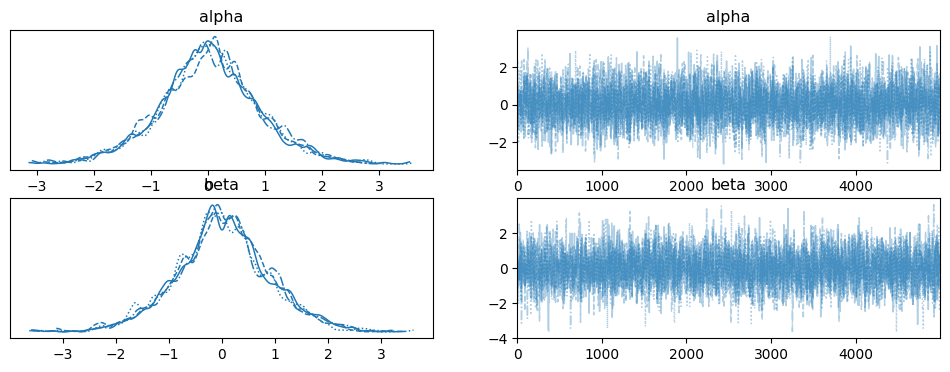

In [6]:
# Assuming you have a function that calculates the likelihood of observing your data
# given alpha and beta
def calculate_likelihood(alpha, beta, observed_transitions):
    # This function should return the likelihood of observing the transitions
    # given alpha and beta. Placeholder implementation here.
    return np.exp(-alpha**2 - beta**2)  # Simplified example


observed_transitions = np.array([0.1, 0.2, 0.3, 0.4])  

with pm.Model() as model:
    # Priors for unknown model parameters alpha and beta
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1)
    
    # Likelihood (sampling distribution) of observations
    likelihood = pm.DensityDist('likelihood', lambda v: calculate_likelihood(alpha, beta, observed_transitions), observed={'v': observed_transitions})

    # Draw 5000 posterior samples using Metropolis-Hastings
    trace = pm.sample(5000, step=pm.Metropolis())
pm.traceplot(trace)
pm.summary(trace).round(2)


### Use the average of the values calculated in no.10 as the most likely final values for alpha and beta in the logistic function. ###
 ### Interpret the results obtained and provide the answer to the question you formulated in no. 9. ###

 Top-Left Plot: This shows the posterior distribution of the parameter 

α. The solid line represents the kernel density estimation (KDE), which is a smooth estimate of the probability density function based on the sample data. The dashed lines might represent the confidence interval or some quantiles of the distribution.

Top-Right Plot: This is the trace plot for 

α. Each point represents the value of 

α at a given iteration of the MCMC simulation. This plot is useful for diagnosing the convergence of the MCMC algorithm. A "healthy" trace plot would show a "hairy caterpillar" pattern indicating good mixing and convergence.

Bottom-Left Plot: Similar to the top-left plot, this shows the posterior distribution for the parameter 

β, with the KDE in the solid line and other statistical demarcations in dashed lines.

Bottom-Right Plot: This trace plot shows the values of 

β across the iterations of the MCMC simulation. Just like the top-right plot, this is useful for checking convergence.

In [8]:
import numpy as np
import pymc3 as pm
import pandas as pd

# Load your data
df = pd.read_csv("SyntheticLocationData.csv")
probability_df = df.copy()
total = 88.0  # Replace with the correct total if necessary
columns = ['Museum', 'Concert', 'SportsEvent', 'Restaurant', 'Hike']

# Convert columns to float and calculate probabilities
for column in columns:
    probability_df[column] = probability_df[column].astype('float64') / total

# Assuming we're interested in the transitions between 'Concert' and 'Hike',
# and between 'Hike' and 'Restaurant' as an example
observed_transitions = probability_df[['Concert', 'Hike', 'Restaurant']].values

# Define the likelihood function based on your transitions
def calculate_likelihood(alpha, beta, observed_transitions):

    return np.exp(-alpha**2 - beta**2)  # Simplified example for demonstration

# Bayesian MCMC Model
with pm.Model() as model:
    # Priors for unknown model parameters alpha and beta
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1)
    
    # Likelihood (sampling distribution) of observations
    likelihood = pm.DensityDist('likelihood',
                                lambda v: calculate_likelihood(alpha, beta, observed_transitions),
                                observed={'v': observed_transitions})

    # Draw 5000 posterior samples using Metropolis-Hastings
    trace = pm.sample(5000, step=pm.Metropolis())

# Calculate the averages of alpha and beta
alpha_mean = np.mean(trace['alpha'])
beta_mean = np.mean(trace['beta'])

# Here's how you'd use them in a logistic function
def logistic_function(x, alpha, beta):
    return 1 / (1 + np.exp(-(alpha + beta * x)))

# Assuming you want to apply the logistic function over some input range
x_values = np.linspace(-10, 10, 100)  # Example range of x
logistic_probabilities = logistic_function(x_values, alpha_mean, beta_mean)

# You can now use 'logistic_probabilities' as the most likely probabilities
# according to the logistic function parameterized by the means of alpha and beta


c:\Users\David\AppData\Local\Programs\Python\Python310\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 33 seconds.
The number of effective samples is smaller than 25% for some parameters.


 Effective sample size (ESS) is a measure of how many of the sampled points are effectively independent and informative. Because of the autocorrelation in the MCMC sampling process (consecutive samples are not completely independent), the effective sample size is generally less than the actual number of samples. If the ESS is small relative to the total number of samples drawn, this could indicate issues such as high autocorrelation, which might mean that the chain is exploring the parameter space inefficiently. 

